### Assignment 3: RNN for predicting Google Stock Price

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tqdm as tqdm 

import tensorflow as tf 

import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import seaborn as sns

# Importing the Keras libraries and packages
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import Dropout

from keras import backend as K

In [2]:
# examine validation accuracy and loss over epochs (during training)

train_dataset = pd.read_csv("Google_Stock_Price_Train.csv", parse_dates=['Date'], index_col="Date")
test_dataset = pd.read_csv("Google_Stock_Price_Test.csv", parse_dates=['Date'], index_col="Date")

print(train_dataset.shape, test_dataset.shape)

(1258, 5) (20, 5)


In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

LEARNING_RATE = 0.0001

device

device(type='cpu')

In [19]:
# common methods
def save_checkpoint(model, optimizer, filename):
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def r_squared(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - (ss_res / ss_tot)
    return r2

def plot_rmse(rmse, val_rmse):
    plt.plot(rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.title('RMSE over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def plot_loss(loss, val_loss):
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_r_squared(rsquared, val_r_squared):
    plt.plot(rsquared, label='Training R-Squared')
    plt.plot(val_r_squared, label='Validation R-Squared')
    plt.title('R-Squared over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('R-Squared')
    plt.legend()
    plt.show()

### Preprocessing data:


In [213]:
idx=round(train_dataset.shape[0] * 0.8)
train_dataset.iloc[idx]

Open          743.0
High         744.06
Low          731.26
Close        741.84
Volume    3,272,800
Name: 2016-01-04 00:00:00, dtype: object

In [5]:
####################
# Preprocessing
##################
# Split the data into training and validation
train_data = train_dataset[train_dataset.index < "2016-01-04"].loc[:,['Close']].replace({',': ''}, regex=True).astype(float).values
val_data = train_dataset[train_dataset.index >= "2016-01-04"].loc[:,['Close']].replace({',': ''}, regex=True).astype(float).values
print(train_data.shape[0], val_data.shape[0])

# Normalization
scaler = MinMaxScaler(feature_range = (0,1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.fit_transform(val_data)

# Creating a data structure with 60 timesteps and 1 output
X = []
y = []
timesteps = 60
# RNN is going to predict 1 output based on prev. 60 stock prices
for i in range(timesteps, train_scaled.shape[0]):
    X.append(train_scaled[i-timesteps:i, 0]) # prev. 60 stock prices
    y.append(train_scaled[i, 0]) # "today" stock price
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

X1 = []
y1 = []
for i in range(timesteps, val_scaled.shape[0]):
    X1.append(val_scaled[i-timesteps:i, 0])
    y1.append(val_scaled[i, 0]) 
X1, y1 = np.array(X1), np.array(y1)
print(X1.shape)
print(y1.shape)

# Reshape (cuz RNN takes 3 dimensional inputs)
X_train = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_val = np.reshape(X1, (X1.shape[0], X1.shape[1], 1))
y_train = y
y_val = y1
print(X_train.shape) # Dimension of array is 3.
print(X_val.shape)



1006 252
(946, 60)
(946,)
(192, 60)
(192,)
(946, 60, 1)
(192, 60, 1)


### Vanilla RNN:


In [54]:
# Initialising the RNN
activation_function = "tanh"
dropout_rate = 0.2
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='loss',  
    mode="auto",
    verbose=1,
    patience=5         # Number of epochs to wait
)
num_epochs=50


# Model
regressor1 = Sequential()            
regressor1.add(SimpleRNN(units = timesteps, activation=activation_function,return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor1.add(Dropout(dropout_rate))
regressor1.add(SimpleRNN(units = timesteps, activation=activation_function,return_sequences = False))
regressor1.add(Dropout(dropout_rate))    
regressor1.add(Dense(units = 1))
regressor1.summary()

Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_116 (SimpleRNN)  (None, 60, 60)            3720      
                                                                 
 dropout_346 (Dropout)       (None, 60, 60)            0         
                                                                 
 simple_rnn_117 (SimpleRNN)  (None, 60)                7260      
                                                                 
 dropout_347 (Dropout)       (None, 60)                0         
                                                                 
 dense_173 (Dense)           (None, 1)                 61        
                                                                 
Total params: 11041 (43.13 KB)
Trainable params: 11041 (43.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# Compiling the RNN
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
regressor1.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse])
# Training...
history1 = regressor1.fit(X_train, y_train, epochs = num_epochs, batch_size = 128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 3s 111ms/step - loss: 0.1551 - rmse: 0.3033 - val_loss: 0.1274 - val_rmse: 0.3009
Epoch 2/50
8/8 [==============================] - 0s 49ms/step - loss: 0.1191 - rmse: 0.2617 - val_loss: 0.0678 - val_rmse: 0.1960
Epoch 3/50
8/8 [==============================] - 0s 50ms/step - loss: 0.0912 - rmse: 0.2266 - val_loss: 0.0501 - val_rmse: 0.1676
Epoch 4/50
8/8 [==============================] - 0s 52ms/step - loss: 0.0958 - rmse: 0.2279 - val_loss: 0.0489 - val_rmse: 0.1733
Epoch 5/50
8/8 [==============================] - 0s 52ms/step - loss: 0.0732 - rmse: 0.2034 - val_loss: 0.0493 - val_rmse: 0.1763
Epoch 6/50
8/8 [==============================] - 0s 50ms/step - loss: 0.0694 - rmse: 0.1933 - val_loss: 0.0403 - val_rmse: 0.1560
Epoch 7/50
8/8 [==============================] - 0s 47ms/step - loss: 0.0613 - rmse: 0.1805 - val_loss: 0.0344 - val_rmse: 0.1416
Epoch 8/50
8/8 [==============================] - 0s 49ms/step - loss: 0.0583 - rm

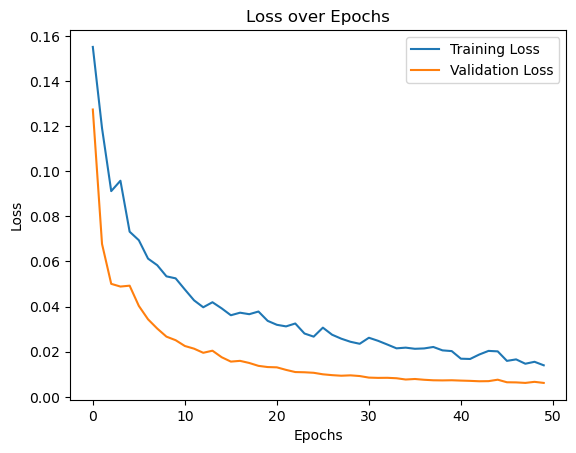

In [56]:
# Training 
# print(history1.history.keys())
# print(history1.history['rmse'])
# print(history1.history['val_rmse'])

plot_loss(history1.history['loss'], history1.history['val_loss'])

### Gated Recurrent Unit (GRU):


In [59]:
regressor2 = Sequential()
        
# Adding the first RNN layer and some Dropout regularisation
regressor2.add(GRU(units = timesteps, activation=activation_function,return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor2.add(Dropout(dropout_rate))
regressor2.add(GRU(units = timesteps, activation=activation_function,return_sequences = False))
regressor2.add(Dropout(dropout_rate))

# output layer
regressor2.add(Dense(units = 1))
regressor2.summary()

Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_118 (GRU)               (None, 60, 60)            11340     
                                                                 
 dropout_348 (Dropout)       (None, 60, 60)            0         
                                                                 
 gru_119 (GRU)               (None, 60)                21960     
                                                                 
 dropout_349 (Dropout)       (None, 60)                0         
                                                                 
 dense_174 (Dense)           (None, 1)                 61        
                                                                 
Total params: 33361 (130.32 KB)
Trainable params: 33361 (130.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

regressor2.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse])

history2 = regressor2.fit(X_train, y_train, epochs = num_epochs, batch_size = 128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 7s 343ms/step - loss: 0.1701 - rmse: 0.3099 - val_loss: 0.3612 - val_rmse: 0.5559
Epoch 2/50
8/8 [==============================] - 2s 192ms/step - loss: 0.1310 - rmse: 0.2632 - val_loss: 0.2832 - val_rmse: 0.4885
Epoch 3/50
8/8 [==============================] - 2s 192ms/step - loss: 0.1016 - rmse: 0.2229 - val_loss: 0.2161 - val_rmse: 0.4227
Epoch 4/50
8/8 [==============================] - 1s 184ms/step - loss: 0.0731 - rmse: 0.1851 - val_loss: 0.1594 - val_rmse: 0.3588
Epoch 5/50
8/8 [==============================] - 1s 184ms/step - loss: 0.0544 - rmse: 0.1578 - val_loss: 0.1122 - val_rmse: 0.2974
Epoch 6/50
8/8 [==============================] - 1s 182ms/step - loss: 0.0353 - rmse: 0.1330 - val_loss: 0.0760 - val_rmse: 0.2427
Epoch 7/50
8/8 [==============================] - 1s 186ms/step - loss: 0.0254 - rmse: 0.1180 - val_loss: 0.0506 - val_rmse: 0.1968
Epoch 8/50
8/8 [==============================] - 1s 182ms/step - loss: 0.02

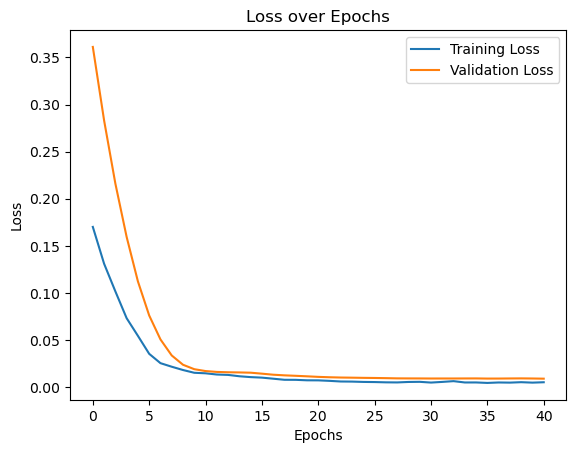

In [61]:
plot_loss(history2.history['loss'], history2.history['val_loss'])


### Long Short-Term Memory (LSTM):

In [62]:
regressor3 = Sequential()
        
# Adding the first RNN layer and some Dropout regularisation
regressor3.add(LSTM(units = timesteps, activation=activation_function,return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor3.add(Dropout(dropout_rate))
regressor3.add(LSTM(units = timesteps, activation=activation_function,return_sequences = False))
regressor3.add(Dropout(dropout_rate))

# output layer
regressor3.add(Dense(units = 1))
regressor3.summary()

Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_112 (LSTM)             (None, 60, 60)            14880     
                                                                 
 dropout_350 (Dropout)       (None, 60, 60)            0         
                                                                 
 lstm_113 (LSTM)             (None, 60)                29040     
                                                                 
 dropout_351 (Dropout)       (None, 60)                0         
                                                                 
 dense_175 (Dense)           (None, 1)                 61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# compile the model
regressor3.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse])

# , callbacks=[early_stopping]
# train the model
history3 = regressor3.fit(X_train, y_train, epochs = num_epochs, batch_size = 128, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
8/8 [==============================] - 7s 329ms/step - loss: 0.0976 - rmse: 0.2333 - val_loss: 0.2070 - val_rmse: 0.4144
Epoch 2/50
8/8 [==============================] - 1s 168ms/step - loss: 0.0706 - rmse: 0.1920 - val_loss: 0.1438 - val_rmse: 0.3412
Epoch 3/50
8/8 [==============================] - 1s 166ms/step - loss: 0.0460 - rmse: 0.1493 - val_loss: 0.0892 - val_rmse: 0.2657
Epoch 4/50
8/8 [==============================] - 1s 171ms/step - loss: 0.0257 - rmse: 0.1082 - val_loss: 0.0475 - val_rmse: 0.1903
Epoch 5/50
8/8 [==============================] - 1s 165ms/step - loss: 0.0154 - rmse: 0.0818 - val_loss: 0.0254 - val_rmse: 0.1327
Epoch 6/50
8/8 [==============================] - 1s 166ms/step - loss: 0.0127 - rmse: 0.0762 - val_loss: 0.0208 - val_rmse: 0.1132
Epoch 7/50
8/8 [==============================] - 1s 169ms/step - loss: 0.0143 - rmse: 0.0790 - val_loss: 0.0206 - val_rmse: 0.1131
Epoch 8/50
8/8 [==============================] - 1s 168ms/step - loss: 0.01

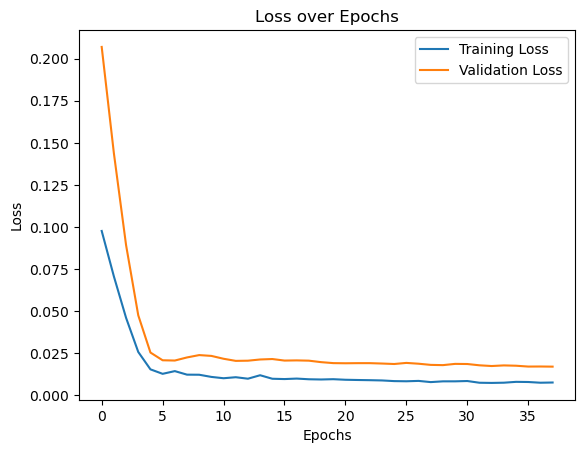

In [64]:
plot_loss(history3.history['loss'], history3.history['val_loss'])


### Optimizing hyperparameter (SimpleRNN)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
import numpy as np

# Define ranges for hyperparameters
units_list = [32, 128]
dropout_rates = [0.2, 0.3, 0.4]
learning_rates = [1e-2, 1e-3, 1e-4]
batch_sizes = [32, 64, 128]

best_val_loss = float('inf')
best_params = {}

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"Testing: units={units}, dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")
                
                # Build the model
                model = Sequential()
                model.add(SimpleRNN(units=units, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(Dropout(dropout_rate))
                model.add(SimpleRNN(units=units, activation='tanh', return_sequences=False))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                # Compile the model
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmse])
                # Train the model
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], epochs=50, batch_size=batch_size)

                # Get the validation loss
                val_loss = min(history.history['val_loss'])

                # Save the best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = {'units': units, 'dropout': dropout_rate, 
                                   'learning_rate': learning_rate, 'batch_size': batch_size}

print(f"Best Validation Loss: {best_val_loss}")
print(f"Best Parameters: {best_params}")


Testing: units=32, dropout=0.2, lr=0.01, batch_size=32
Epoch 1/50
30/30 [==============================] - 3s 35ms/step - loss: 0.1460 - rmse: 0.2596 - val_loss: 0.0106 - val_rmse: 0.0754
Epoch 2/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0280 - rmse: 0.1249 - val_loss: 0.0082 - val_rmse: 0.0692
Epoch 3/50
30/30 [==============================] - 1s 23ms/step - loss: 0.0137 - rmse: 0.0875 - val_loss: 0.0071 - val_rmse: 0.0638
Epoch 4/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0103 - rmse: 0.0755 - val_loss: 0.0061 - val_rmse: 0.0580
Epoch 5/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0079 - rmse: 0.0623 - val_loss: 0.0057 - val_rmse: 0.0569
Epoch 6/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0075 - rmse: 0.0598 - val_loss: 0.0085 - val_rmse: 0.0772
Epoch 7/50
30/30 [==============================] - 1s 22ms/step - loss: 0.0053 - rmse: 0.0511 - val_loss: 0.0052 - val_rmse: 0.0545
Epoch 8/50
30/

### Optimizing hyperparameter (GRU)

In [17]:
best_val_loss1 = float('inf')
best_params1 = {}

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"Testing: units={units}, dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")
                
                # Build the model
                model = Sequential()
                model.add(GRU(units=units, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(Dropout(dropout_rate))
                model.add(GRU(units=units, activation='tanh', return_sequences=False))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                # Compile the model
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmse])
                # Train the model
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], epochs=50, batch_size=batch_size)

                # Get the validation loss
                val_loss = min(history.history['val_loss'])

                # Save the best model
                if val_loss < best_val_loss1:
                    best_val_loss1 = val_loss
                    best_params1 = {'units': units, 'dropout': dropout_rate, 
                                   'learning_rate': learning_rate, 'batch_size': batch_size}

print(f"Best Validation Loss: {best_val_loss1}")
print(f"Best Parameters: {best_params1}")

Testing: units=32, dropout=0.2, lr=0.01, batch_size=32
Epoch 1/50
30/30 [==============================] - 7s 80ms/step - loss: 0.0191 - rmse: 0.0978 - val_loss: 0.0148 - val_rmse: 0.1078
Epoch 2/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0050 - rmse: 0.0453 - val_loss: 0.0050 - val_rmse: 0.0554
Epoch 3/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0029 - rmse: 0.0327 - val_loss: 0.0038 - val_rmse: 0.0456
Epoch 4/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0035 - rmse: 0.0375 - val_loss: 0.0068 - val_rmse: 0.0688
Epoch 5/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0026 - rmse: 0.0324 - val_loss: 0.0038 - val_rmse: 0.0461
Epoch 6/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0026 - rmse: 0.0297 - val_loss: 0.0061 - val_rmse: 0.0645
Epoch 7/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0028 - rmse: 0.0337 - val_loss: 0.0045 - val_rmse: 0.0528
Epoch 8/50
30/

### Optimizing hyperparameter (LSTM)

In [18]:
best_val_loss2 = float('inf')
best_params2 = {}

for units in units_list:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            for batch_size in batch_sizes:
                print(f"Testing: units={units}, dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")
                
                # Build the model
                model = Sequential()
                model.add(LSTM(units=units, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 1)))
                model.add(Dropout(dropout_rate))
                model.add(LSTM(units=units, activation='tanh', return_sequences=False))
                model.add(Dropout(dropout_rate))
                model.add(Dense(1))

                # Compile the model
                optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
                model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmse])
                # Train the model
                history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping], epochs=50, batch_size=batch_size)

                # Get the validation loss
                val_loss = min(history.history['val_loss'])

                # Save the best model
                if val_loss < best_val_loss2:
                    best_val_loss2 = val_loss
                    best_params2 = {'units': units, 'dropout': dropout_rate, 
                                   'learning_rate': learning_rate, 'batch_size': batch_size}

print(f"Best Validation Loss: {best_val_loss2}")
print(f"Best Parameters: {best_params2}")

Testing: units=32, dropout=0.2, lr=0.01, batch_size=32
Epoch 1/50
30/30 [==============================] - 7s 79ms/step - loss: 0.0155 - rmse: 0.0767 - val_loss: 0.0141 - val_rmse: 0.0999
Epoch 2/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0058 - rmse: 0.0477 - val_loss: 0.0088 - val_rmse: 0.0726
Epoch 3/50
30/30 [==============================] - 1s 44ms/step - loss: 0.0061 - rmse: 0.0467 - val_loss: 0.0084 - val_rmse: 0.0709
Epoch 4/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0044 - rmse: 0.0395 - val_loss: 0.0075 - val_rmse: 0.0685
Epoch 5/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0034 - rmse: 0.0346 - val_loss: 0.0079 - val_rmse: 0.0723
Epoch 6/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0038 - rmse: 0.0364 - val_loss: 0.0061 - val_rmse: 0.0603
Epoch 7/50
30/30 [==============================] - 1s 42ms/step - loss: 0.0031 - rmse: 0.0325 - val_loss: 0.0071 - val_rmse: 0.0682
Epoch 8/50
30/

### Retrain with best parameters (SimpleRNN)

In [21]:
# Best Parameters: {'units': 32, 'dropout': 0.3, 'learning_rate': 0.01, 'batch_size': 32}

regressor4 = Sequential()
        
# Adding the first RNN layer and some Dropout regularisation
regressor4.add(SimpleRNN(units = 32, activation="tanh",return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor4.add(Dropout(0.3))
regressor4.add(SimpleRNN(units = 32, activation="tanh",return_sequences = False))
regressor4.add(Dropout(0.3))
regressor4.add(Dense(units = 1))
regressor4.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model
regressor4.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse, r_squared])

# , callbacks=[early_stopping]
# train the model
history4 = regressor4.fit(X_train, y_train, epochs = num_epochs, batch_size = 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_112 (SimpleRNN)  (None, 60, 32)            1088      
                                                                 
 dropout_334 (Dropout)       (None, 60, 32)            0         
                                                                 
 simple_rnn_113 (SimpleRNN)  (None, 32)                2080      
                                                                 
 dropout_335 (Dropout)       (None, 32)                0         
                                                                 
 dense_167 (Dense)           (None, 1)                 33        
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
30/30 [

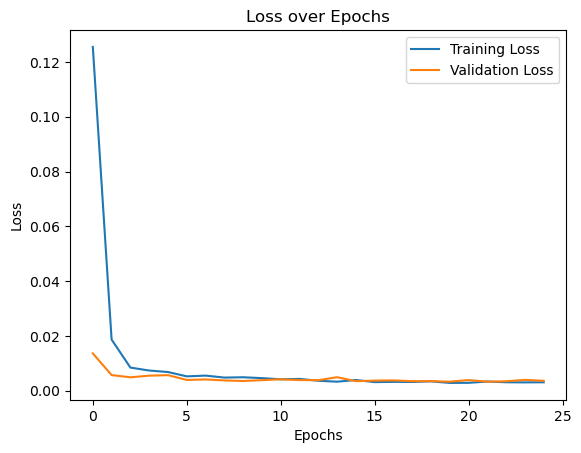

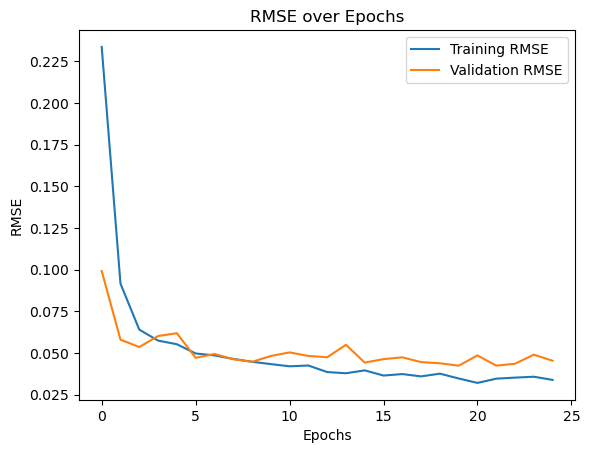

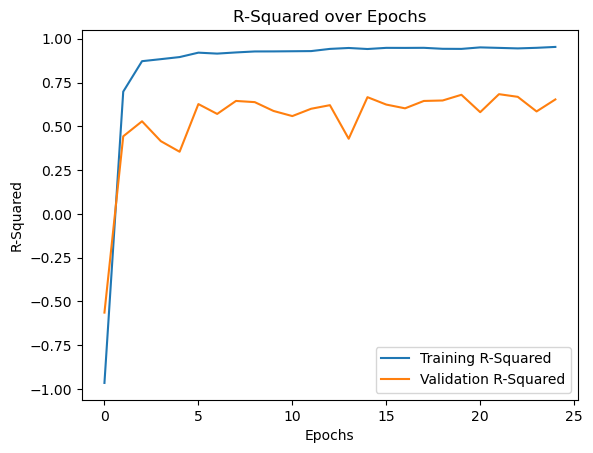

In [35]:
plot_loss(history4.history['loss'], history4.history['val_loss'])
plot_rmse(history4.history['rmse'], history4.history['val_rmse'])
plot_r_squared(history4.history['r_squared'], history4.history['val_r_squared'])

### Retrain with best parameters (GRU)

In [24]:
# Best Parameters: {'units': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 32}

regressor5 = Sequential()
        
# Adding the first RNN layer and some Dropout regularisation
regressor5.add(GRU(units = 32, activation="tanh",return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor5.add(Dropout(0.2))
regressor5.add(GRU(units = 32, activation="tanh",return_sequences = False))
regressor5.add(Dropout(0.2))
regressor5.add(Dense(units = 1))
regressor5.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model
regressor5.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse, r_squared])

# , callbacks=[early_stopping]
# train the model
history5 = regressor5.fit(X_train, y_train, epochs = num_epochs, batch_size = 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_114 (GRU)               (None, 60, 32)            3360      
                                                                 
 dropout_338 (Dropout)       (None, 60, 32)            0         
                                                                 
 gru_115 (GRU)               (None, 32)                6336      
                                                                 
 dropout_339 (Dropout)       (None, 32)                0         
                                                                 
 dense_169 (Dense)           (None, 1)                 33        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
30/30 [

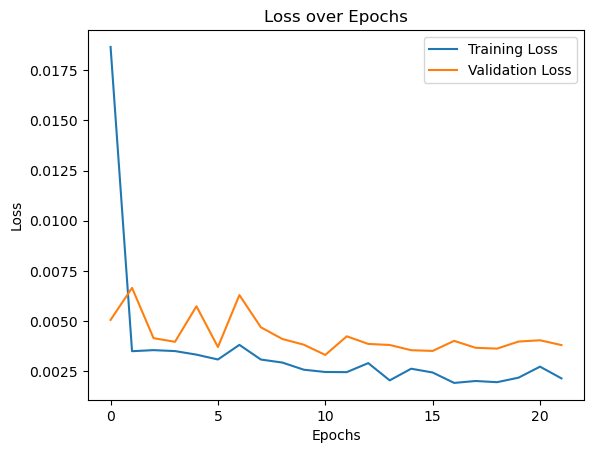

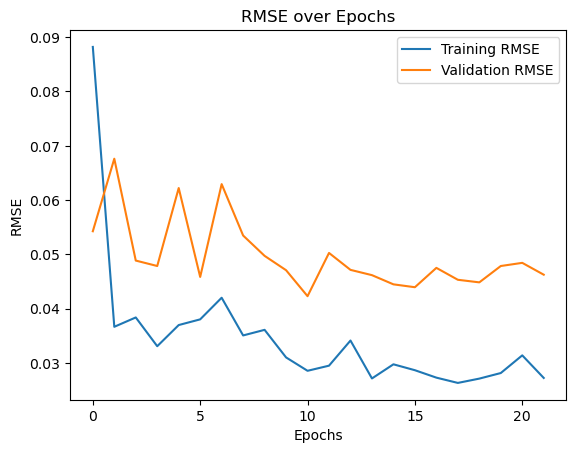

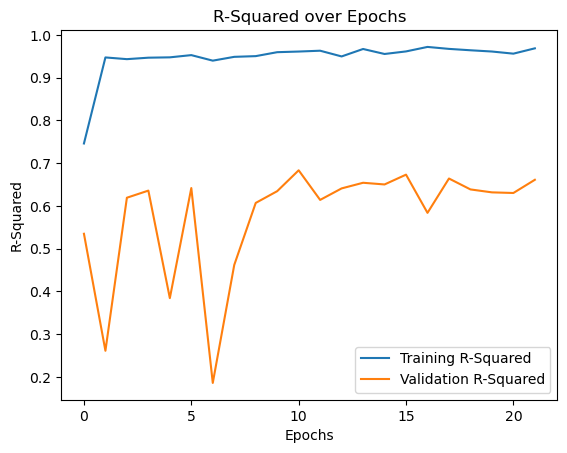

In [33]:
plot_loss(history5.history['loss'], history5.history['val_loss'])
plot_rmse(history5.history['rmse'], history5.history['val_rmse'])
plot_r_squared(history5.history['r_squared'], history5.history['val_r_squared'])

### Retrain with best parameters (LSTM)

In [26]:
# Best Parameters: {'units': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 32}

regressor6 = Sequential()
        
regressor6.add(LSTM(units = 32, activation="tanh",return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor6.add(Dropout(0.2))
regressor6.add(LSTM(units = 32, activation="tanh",return_sequences = False))
regressor6.add(Dropout(0.2))

# output layer
regressor6.add(Dense(units = 1))
regressor6.summary()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# compile the model
regressor6.compile(optimizer = optimizer, loss='mean_squared_error', metrics=[rmse, r_squared])

# , callbacks=[early_stopping]
# train the model
history6 = regressor6.fit(X_train, y_train, epochs = num_epochs, batch_size = 32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_110 (LSTM)             (None, 60, 32)            4352      
                                                                 
 dropout_340 (Dropout)       (None, 60, 32)            0         
                                                                 
 lstm_111 (LSTM)             (None, 32)                8320      
                                                                 
 dropout_341 (Dropout)       (None, 32)                0         
                                                                 
 dense_170 (Dense)           (None, 1)                 33        
                                                                 
Total params: 12705 (49.63 KB)
Trainable params: 12705 (49.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
30/30

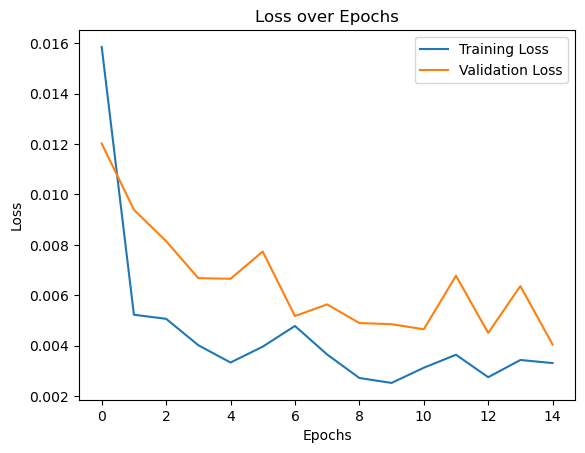

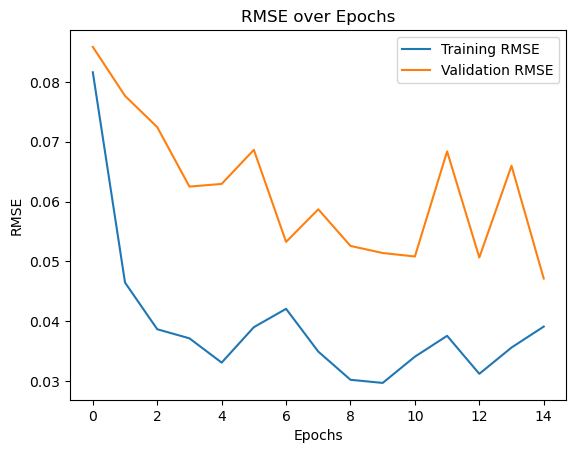

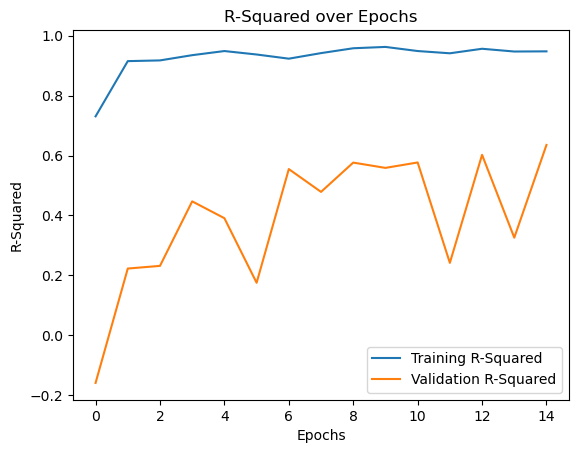

In [34]:
plot_loss(history6.history['loss'], history6.history['val_loss'])
plot_rmse(history6.history['rmse'], history6.history['val_rmse'])
plot_r_squared(history6.history['r_squared'], history6.history['val_r_squared'])

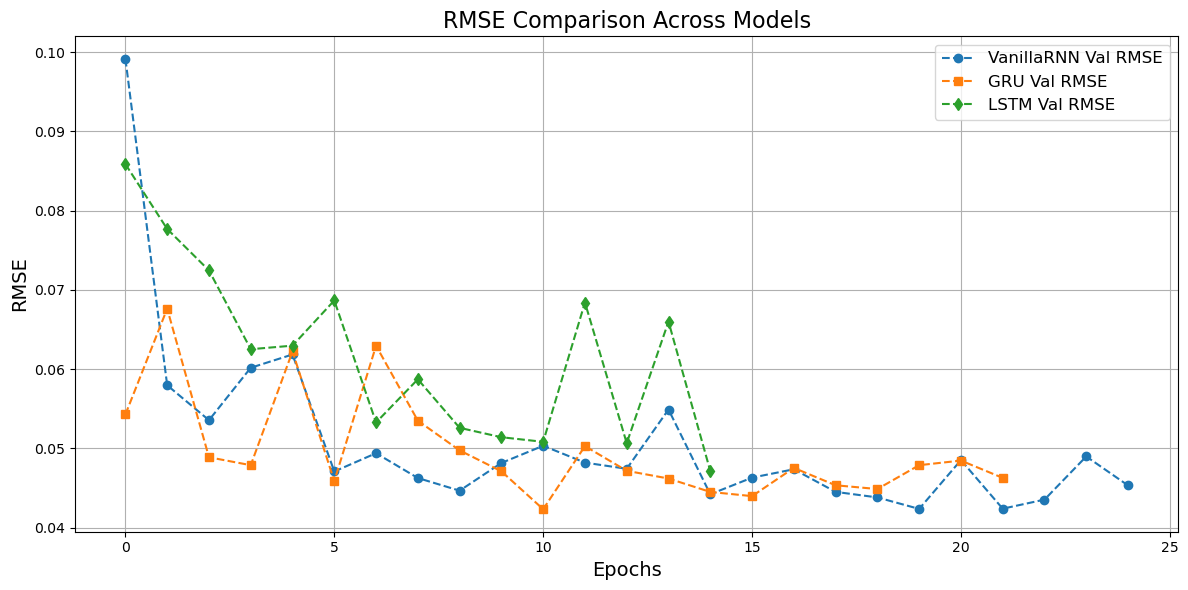

In [36]:
### Evaluation metrics
##### RMSE
plt.figure(figsize=(12, 6))

# Plot history4
# plt.plot(history4.history['rmse'], label='VanillaRNN Train RMSE', linestyle='-', marker='o')
plt.plot(history4.history['val_rmse'], label='VanillaRNN Val RMSE', linestyle='--', marker='o')

# Plot history5
# plt.plot(history5.history['rmse'], label='GRU Train RMSE', linestyle='-', marker='s')
plt.plot(history5.history['val_rmse'], label='GRU Val RMSE', linestyle='--', marker='s')

# Plot history6
# plt.plot(history6.history['rmse'], label='LSTM Train RMSE', linestyle='-', marker='d')
plt.plot(history6.history['val_rmse'], label='LSTM Val RMSE', linestyle='--', marker='d')

# Customize the plot
plt.title('RMSE Comparison Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

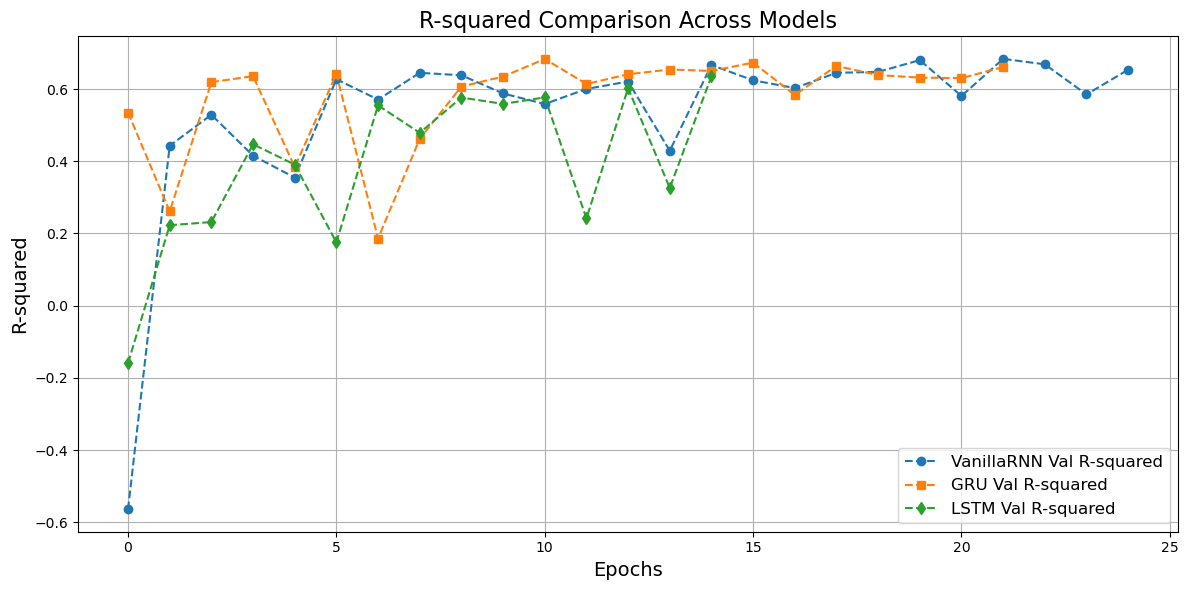

In [38]:
plt.figure(figsize=(12, 6))

# Plot history4
plt.plot(history4.history['val_r_squared'], label='VanillaRNN Val R-squared', linestyle='--', marker='o')

# Plot history5
plt.plot(history5.history['val_r_squared'], label='GRU Val R-squared', linestyle='--', marker='s')

# Plot history6
plt.plot(history6.history['val_r_squared'], label='LSTM Val R-squared', linestyle='--', marker='d')

# Customize the plot
plt.title('R-squared Comparison Across Models', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('R-squared', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

### Compare real stock price with predicted stock price 

#### Before optimizing hyperparameters:

In [65]:
real_stock_price = test_dataset.loc[:,['Open']].values
print(real_stock_price.shape)

# Getting predicted stock prices of month Jan 2017
# Combine both training and test for prediction
dataset_total = pd.concat([train_dataset["Open"], test_dataset["Open"]], axis=0)

# stock prices of prev. 50 days for each day of Jan 2017
inputs = dataset_total[len(dataset_total)-len(test_dataset)-timesteps:].values
inputs.shape

# reshape (numpy array, fit into RNN)
inputs = inputs.reshape(-1,1)

# feature scaling
inputs = scaler.transform(inputs)
inputs.shape

# create test set
# Getting prev. 60 days stock prices of each day in month Jan 2017
X_test = []
print(timesteps, inputs.shape[0])
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0]) # prev. 50 stock prices

X_test = np.array(X_test)
print(X_test.shape)

# reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# getting predicted stock price from model
predicted_stock_price1 = regressor1.predict(X_test)
predicted_stock_price1 = scaler.inverse_transform(predicted_stock_price1)
predicted_stock_price2 = regressor2.predict(X_test)
predicted_stock_price2 = scaler.inverse_transform(predicted_stock_price2)
predicted_stock_price3 = regressor3.predict(X_test)
predicted_stock_price3 = scaler.inverse_transform(predicted_stock_price3)

print(predicted_stock_price1[:5], real_stock_price[:5])

(20, 1)
60 80
(20, 60)
1/1 [==============================] - 1s 1s/step
[[783.7848]
 [784.911 ]
 [782.8792]
 [785.6226]
 [779.4285]] [[778.81]
 [788.36]
 [786.08]
 [795.26]
 [806.4 ]]


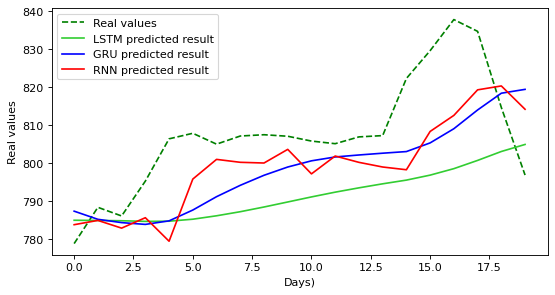

In [66]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(real_stock_price,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_stock_price3,color="limegreen", label="LSTM predicted result")
plt.plot(predicted_stock_price2,color="blue", label="GRU predicted result")
plt.plot(predicted_stock_price1,color="red",label="RNN predicted result") # ben ekledim
plt.legend()
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.legend()
plt.show()

#### AFTER optimizing hyperparameters:

1/1 [==============================] - 0s 35ms/step
[[784.5857 ]
 [781.5618 ]
 [788.53845]
 [786.5584 ]
 [793.77606]] [[778.81]
 [788.36]
 [786.08]
 [795.26]
 [806.4 ]]


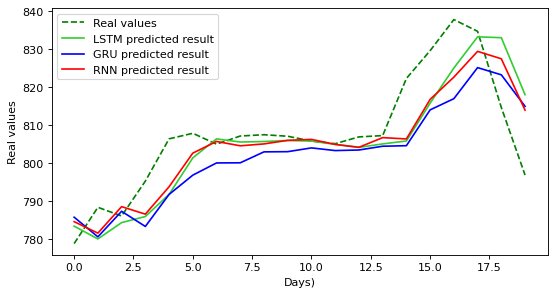

In [67]:
# getting predicted stock price from model
predicted_stock_price1 = regressor4.predict(X_test)
predicted_stock_price1 = scaler.inverse_transform(predicted_stock_price1)
predicted_stock_price2 = regressor5.predict(X_test)
predicted_stock_price2 = scaler.inverse_transform(predicted_stock_price2)
predicted_stock_price3 = regressor6.predict(X_test)
predicted_stock_price3 = scaler.inverse_transform(predicted_stock_price3)

print(predicted_stock_price1[:5], real_stock_price[:5])

plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(real_stock_price,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_stock_price3,color="limegreen", label="LSTM predicted result")
plt.plot(predicted_stock_price2,color="blue", label="GRU predicted result")
plt.plot(predicted_stock_price1,color="red",label="RNN predicted result") # ben ekledim
plt.legend()
plt.xlabel("Days)")
plt.ylabel("Real values")
plt.legend()
plt.show()